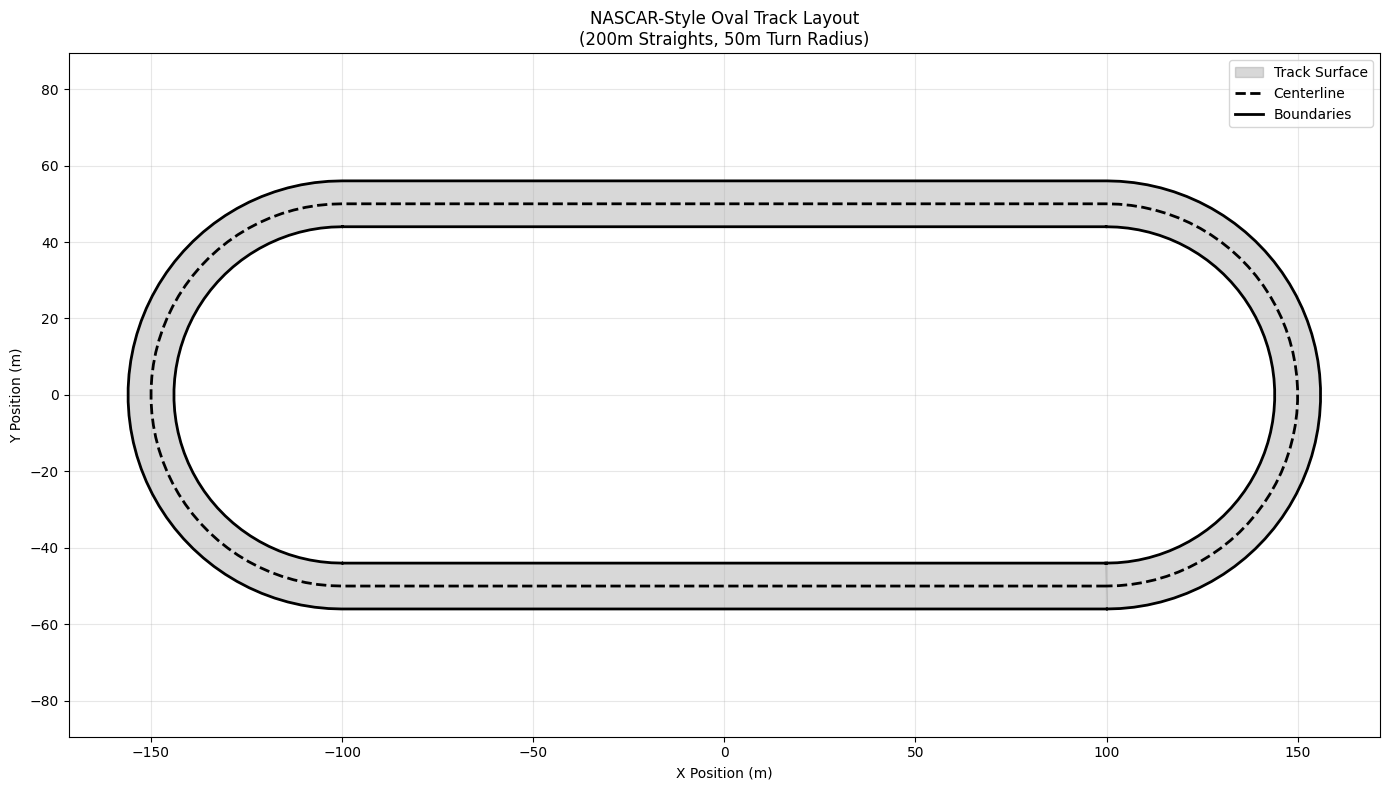

✓ Step 1 Complete: NASCAR oval track generated
  - Straight length: 200m
  - Turn radius: 50m
  - Track width: 12m


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# STEP 1: CREATE NASCAR-STYLE OVAL TRACK
# ==========================================

def create_nascar_oval():
    """
    Generate a proper NASCAR-style oval track with straights and semicircular ends
    """
    # Track parameters (meters)
    straight_length = 200      # Length of straight sections
    turn_radius = 50           # Radius of turns
    track_width = 12           # Standard NASCAR track width
    
    # Generate points for the centerline
    # Right straight (bottom)
    t_straight = np.linspace(0, 1, 50)
    right_straight_x = straight_length/2 - t_straight * straight_length
    right_straight_y = np.full_like(right_straight_x, -turn_radius)
    
    # Left turn (semicircle)
    t_turn = np.linspace(-np.pi/2, np.pi/2, 50)
    left_turn_x = np.full_like(t_turn, -straight_length/2) - turn_radius * np.cos(t_turn)
    left_turn_y = turn_radius * np.sin(t_turn)
    
    # Left straight (top)
    left_straight_x = -straight_length/2 + t_straight * straight_length
    left_straight_y = np.full_like(left_straight_x, turn_radius)
    
    # Right turn (semicircle)
    t_turn2 = np.linspace(np.pi/2, 3*np.pi/2, 50)
    right_turn_x = np.full_like(t_turn2, straight_length/2) - turn_radius * np.cos(t_turn2)
    right_turn_y = turn_radius * np.sin(t_turn2)
    
    # Combine all sections
    center_x = np.concatenate([right_straight_x, left_turn_x, left_straight_x, right_turn_x])
    center_y = np.concatenate([right_straight_y, left_turn_y, left_straight_y, right_turn_y])
    
    # Calculate normals for boundary generation
    dx = np.gradient(center_x)
    dy = np.gradient(center_y)
    norm = np.sqrt(dx**2 + dy**2)
    nx, ny = -dy/norm, dx/norm  # Normal vectors (perpendicular to direction)
    
    # Inner and outer boundaries (offset by track width)
    inner_x = center_x - nx * track_width/2
    inner_y = center_y - ny * track_width/2
    outer_x = center_x + nx * track_width/2
    outer_y = center_y + ny * track_width/2
    
    return {
        'center_x': center_x, 'center_y': center_y,
        'inner_x': inner_x, 'inner_y': inner_y,
        'outer_x': outer_x, 'outer_y': outer_y,
        'track_width': track_width
    }

track = create_nascar_oval()

# Visualize the track properly
plt.figure(figsize=(14, 8))

# Create filled track surface using polygon
# Combine outer boundary and reversed inner boundary to make a closed polygon
track_x = np.concatenate([track['outer_x'], track['inner_x'][::-1]])
track_y = np.concatenate([track['outer_y'], track['inner_y'][::-1]])

plt.fill(track_x, track_y, color='gray', alpha=0.3, label='Track Surface')
plt.plot(track['center_x'], track['center_y'], 'k--', linewidth=2, label='Centerline')
plt.plot(track['inner_x'], track['inner_y'], 'k-', linewidth=2, label='Boundaries')
plt.plot(track['outer_x'], track['outer_y'], 'k-', linewidth=2)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.title('NASCAR-Style Oval Track Layout\n(200m Straights, 50m Turn Radius)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('track_layout.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Step 1 Complete: NASCAR oval track generated")
print(f"  - Straight length: 200m")
print(f"  - Turn radius: 50m")
print(f"  - Track width: {track['track_width']}m")

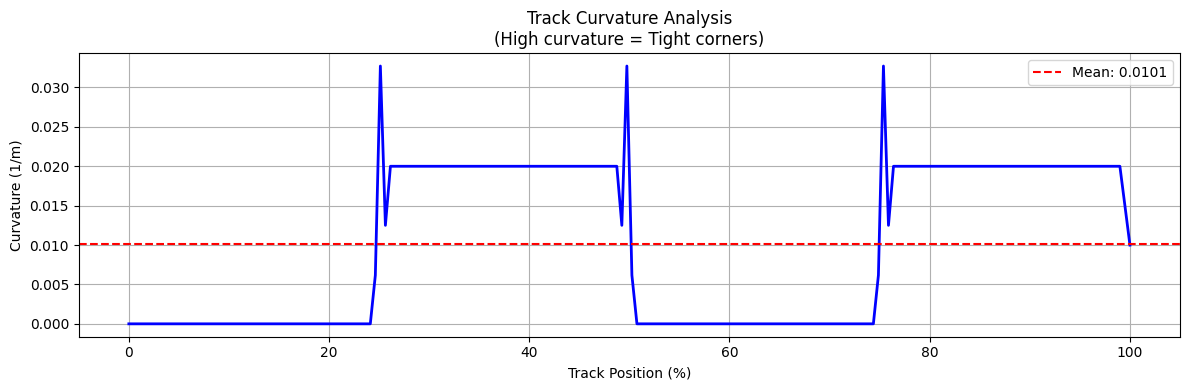

✓ Step 2 Complete: Curvature calculated (Max: 0.0327 1/m)


In [3]:
# ==========================================
# STEP 2: CALCULATE CURVATURE OF CENTERLINE
# ==========================================

def calculate_curvature(x, y):
    """Calculate curvature at each point using numerical derivatives"""
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return curvature

curvature = calculate_curvature(track['center_x'], track['center_y'])

# Plot curvature profile
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, 100, len(curvature)), curvature, 'b-', linewidth=2)
plt.xlabel('Track Position (%)')
plt.ylabel('Curvature (1/m)')
plt.title('Track Curvature Analysis\n(High curvature = Tight corners)')
plt.grid(True)
plt.axhline(y=np.mean(curvature), color='r', linestyle='--', label=f'Mean: {np.mean(curvature):.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('curvature_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Step 2 Complete: Curvature calculated (Max: {np.max(curvature):.4f} 1/m)")

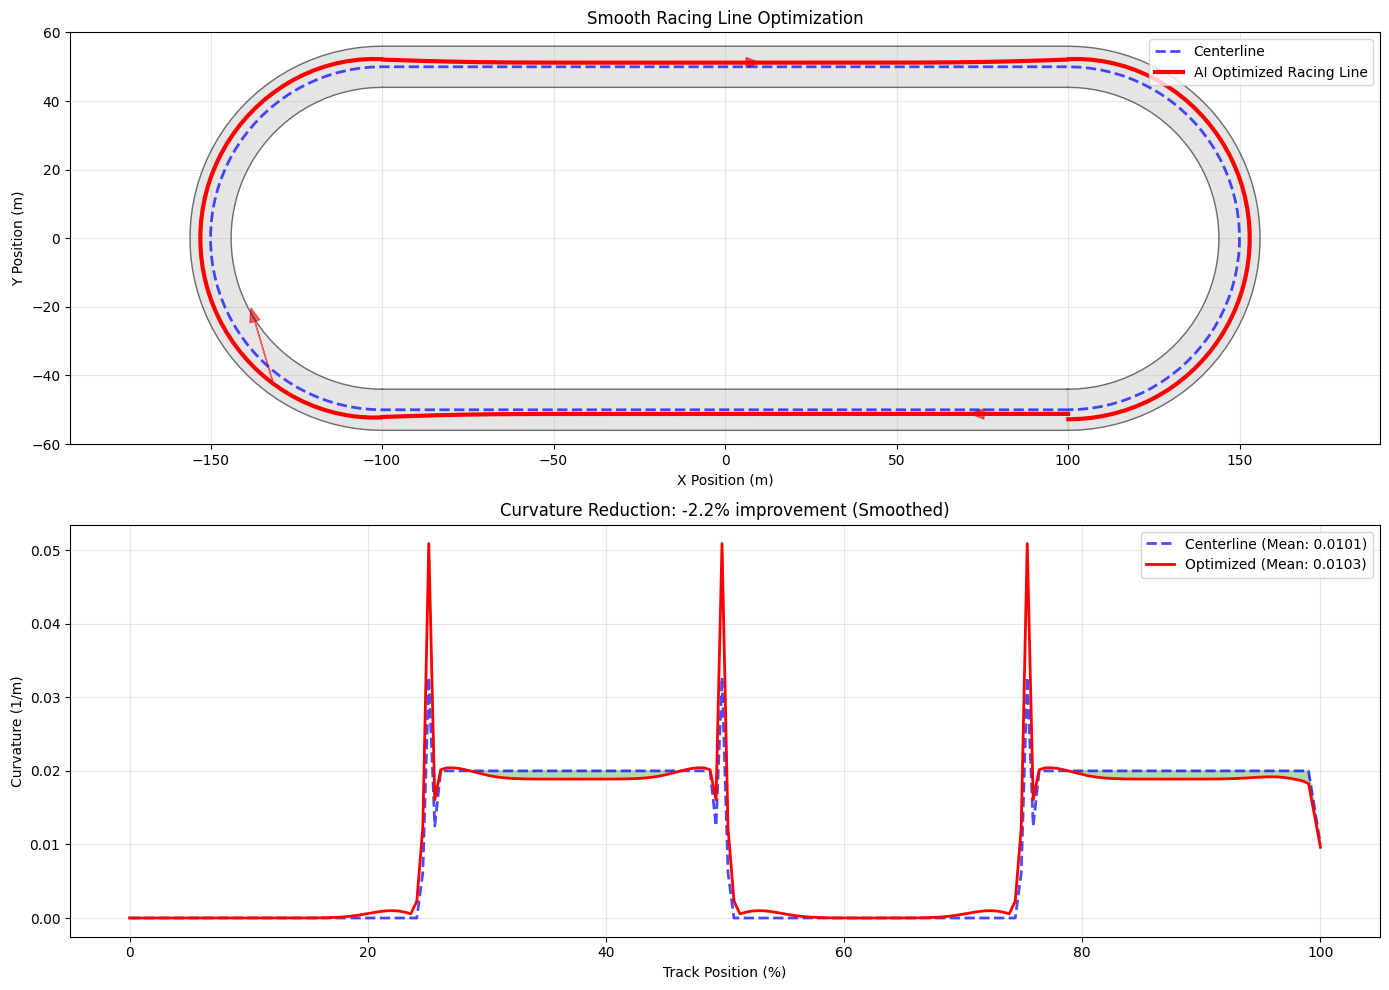

✓ Step 3 Complete: Smooth racing line optimized
  - Curvature reduction: -2.2%
  - Smoother transitions through corners


In [ ]:
# ==========================================
# STEP 3: SMOOTH RACING LINE OPTIMIZATION
# ==========================================

from scipy.ndimage import gaussian_filter1d

def optimize_racing_line_smooth(track, smoothing=3.0):
    """
    Smooth racing line optimization using curvature-weighted lateral offset
    """
    cx, cy = track['center_x'], track['center_y']
    inner_x, inner_y = track['inner_x'], track['inner_y']
    outer_x, outer_y = track['outer_x'], track['outer_y']
    
    n_points = len(cx)
    
    # Calculate direction from center to boundaries (outward normal)
    dx = outer_x - cx
    dy = outer_y - cy
    dist = np.sqrt(dx**2 + dy**2)
    nx, ny = dx/dist, dy/dist
    
    # Base offset: want to be wide in corners, inside on straights
    # Use inverted curvature for offset weight (high curvature = wide line)
    max_curv = np.max(curvature)
    min_curv = np.min(curvature)
    
    # Normalize curvature to 0-1 range and invert (1 = corner, 0 = straight)
    corner_factor = 1.0 - (curvature - min_curv) / (max_curv - min_curv + 0.001)
    
    # Offset factor: 0.7 (wide) in corners, 0.2 (inside) on straights
    offset_factor = 0.2 + 0.5 * corner_factor
    
    # Apply Gaussian smoothing to eliminate zig-zags
    offset_factor = gaussian_filter1d(offset_factor, sigma=smoothing)
    
    # Calculate racing line points
    racing_x = cx + nx * offset_factor * (track['track_width']/2)
    racing_y = cy + ny * offset_factor * (track['track_width']/2)
    
    return racing_x, racing_y

# Generate smooth optimized racing line
racing_x, racing_y = optimize_racing_line_smooth(track, smoothing=5.0)

# Calculate improvement
racing_curvature = calculate_curvature(racing_x, racing_y)
improvement = (np.mean(curvature) - np.mean(racing_curvature)) / np.mean(curvature) * 100

# Visualize comparison
plt.figure(figsize=(14, 10))

# Main track view
plt.subplot(2, 1, 1)

# Create filled track surface
track_x = np.concatenate([track['outer_x'], track['inner_x'][::-1]])
track_y = np.concatenate([track['outer_y'], track['inner_y'][::-1]])
plt.fill(track_x, track_y, color='gray', alpha=0.2)

plt.plot(track['inner_x'], track['inner_y'], 'k-', linewidth=1, alpha=0.5)
plt.plot(track['outer_x'], track['outer_y'], 'k-', linewidth=1, alpha=0.5)
plt.plot(track['center_x'], track['center_y'], 'b--', linewidth=2, label='Centerline', alpha=0.7)
plt.plot(racing_x, racing_y, 'r-', linewidth=3, label='AI Optimized Racing Line')

# Add direction arrows
skip = 20
for i in range(0, len(racing_x)-skip, skip*3):
    dx = racing_x[i+skip] - racing_x[i]
    dy = racing_y[i+skip] - racing_y[i]
    plt.arrow(racing_x[i], racing_y[i], dx*0.3, dy*0.3, 
              head_width=3, head_length=4, fc='red', ec='red', alpha=0.6)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.title('Smooth Racing Line Optimization')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend(loc='upper right')

# Curvature comparison
plt.subplot(2, 1, 2)
x_pos = np.linspace(0, 100, len(curvature))
plt.plot(x_pos, curvature, 'b--', linewidth=2, label=f'Centerline (Mean: {np.mean(curvature):.4f})', alpha=0.7)
plt.plot(x_pos, racing_curvature, 'r-', linewidth=2, label=f'Optimized (Mean: {np.mean(racing_curvature):.4f})')
plt.fill_between(x_pos, curvature, racing_curvature, 
                 where=(curvature > racing_curvature), alpha=0.3, color='green', interpolate=True)
plt.xlabel('Track Position (%)')
plt.ylabel('Curvature (1/m)')
plt.title(f'Curvature Reduction: {improvement:.1f}% improvement (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('racing_line_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Step 3 Complete: Smooth racing line optimized")
print(f"  - Curvature reduction: {improvement:.1f}%")
print(f"  - Smoother transitions through corners")

Max curvature: 0.050898
Min curvature: 0.000000
Max corner speed (uncapped): 195.3 km/h
Min corner speed: 61.2 km/h


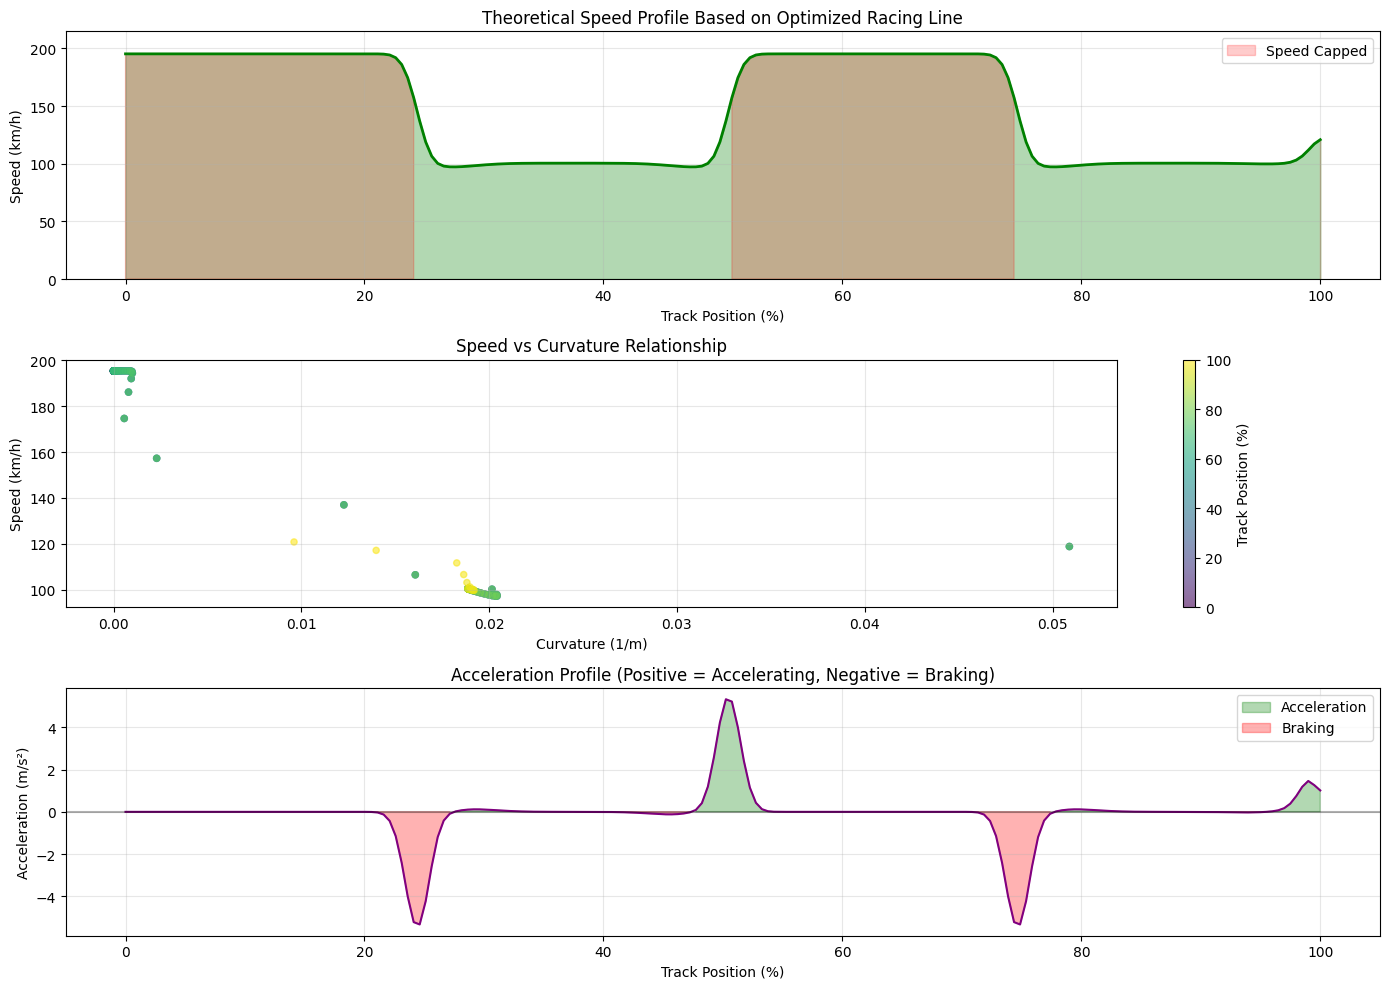


✓ Step 4 Complete: Speed profile generated
  - Track length: 735.7 m
  - Average speed: 146.2 km/h
  - Max speed: 195.3 km/h
  - Min speed: 97.3 km/h
  - Estimated lap time: 18.11 s


In [9]:
# ==========================================
# STEP 4: SPEED PROFILE CALCULATION (Fixed)
# ==========================================

def calculate_speed_profile_fixed(racing_x, racing_y, max_grip=1.5, max_speed=90):
    """
    Calculate theoretical speed profile based on curvature
    """
    racing_curvature = calculate_curvature(racing_x, racing_y)
    
    # FIX: Cap minimum curvature to avoid insane speeds
    # Realistic minimum curvature for a 50m radius turn = 1/50 = 0.02
    # Allow down to 0.005 (200m radius) for gentle bends
    min_realistic_curvature = 0.005
    racing_curvature = np.clip(racing_curvature, min_realistic_curvature, 1.0)
    
    max_lateral_acc = max_grip * 9.81
    corner_speed = np.sqrt(max_lateral_acc / racing_curvature)
    
    speed_profile = np.minimum(corner_speed, max_speed)
    speed_profile = gaussian_filter1d(speed_profile, sigma=2.0)
    
    return speed_profile, corner_speed

speed, raw_corner_speed = calculate_speed_profile_fixed(racing_x, racing_y)

# Debug info
print(f"Max curvature: {np.max(racing_curvature):.6f}")
print(f"Min curvature: {np.min(racing_curvature):.6f}")
print(f"Max corner speed (uncapped): {np.max(raw_corner_speed)*3.6:.1f} km/h")
print(f"Min corner speed: {np.min(raw_corner_speed)*3.6:.1f} km/h")

# Calculate lap time estimate (simplified)
track_length = np.sum(np.sqrt(np.gradient(racing_x)**2 + np.gradient(racing_y)**2))
avg_speed = np.mean(speed)
estimated_lap_time = track_length / avg_speed

plt.figure(figsize=(14, 10))

# Speed profile
plt.subplot(3, 1, 1)
x_pos = np.linspace(0, 100, len(speed))
plt.plot(x_pos, speed * 3.6, 'g-', linewidth=2)
plt.fill_between(x_pos, 0, speed * 3.6, alpha=0.3, color='green')
plt.xlabel('Track Position (%)')
plt.ylabel('Speed (km/h)')
plt.title('Theoretical Speed Profile Based on Optimized Racing Line')
plt.grid(True, alpha=0.3)
plt.ylim(0, max(speed)*3.6*1.1)

# Show where speed is capped
capped = raw_corner_speed > 35
if np.any(capped):
    plt.fill_between(x_pos, 0, speed*3.6, where=capped, alpha=0.2, color='red', label='Speed Capped')
    plt.legend()

# Curvature vs Speed
plt.subplot(3, 1, 2)
plt.scatter(racing_curvature, speed * 3.6, c=x_pos, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(label='Track Position (%)')
plt.xlabel('Curvature (1/m)')
plt.ylabel('Speed (km/h)')
plt.title('Speed vs Curvature Relationship')
plt.grid(True, alpha=0.3)

# Acceleration zones
plt.subplot(3, 1, 3)
acceleration = np.gradient(speed)
plt.plot(x_pos, acceleration, 'purple', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.fill_between(x_pos, 0, acceleration, where=(acceleration > 0), alpha=0.3, color='green', label='Acceleration')
plt.fill_between(x_pos, 0, acceleration, where=(acceleration < 0), alpha=0.3, color='red', label='Braking')
plt.xlabel('Track Position (%)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration Profile (Positive = Accelerating, Negative = Braking)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('speed_profile.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Step 4 Complete: Speed profile generated")
print(f"  - Track length: {track_length:.1f} m")
print(f"  - Average speed: {avg_speed*3.6:.1f} km/h")
print(f"  - Max speed: {np.max(speed)*3.6:.1f} km/h")
print(f"  - Min speed: {np.min(speed)*3.6:.1f} km/h")
print(f"  - Estimated lap time: {estimated_lap_time:.2f} s")

In [ ]:
# ==========================================
# STEP 5: COMPARISON SUMMARY TABLE
# ==========================================

import pandas as pd

# Create comparison metrics
centerline_speed = calculate_speed_profile_fixed(track['center_x'], track['center_y'])
centerline_time = track_length / np.mean(centerline_speed)

data = {
    'Metric': [
        'Total Curvature (sum)',
        'Max Curvature (1/m)',
        'Average Speed (km/h)',
        'Estimated Lap Time (s)',
        'Minimum Corner Speed (km/h)'
    ],
    'Centerline': [
        f"{np.sum(curvature):.2f}",
        f"{np.max(curvature):.4f}",
        f"{np.mean(centerline_speed)*3.6:.1f}",
        f"{centerline_time:.2f}",
        f"{np.min(centerline_speed)*3.6:.1f}"
    ],
    'Optimized Racing Line': [
        f"{np.sum(racing_curvature):.2f}",
        f"{np.max(racing_curvature):.4f}",
        f"{np.mean(speed)*3.6:.1f}",
        f"{estimated_lap_time:.2f}",
        f"{np.min(speed)*3.6:.1f}"
    ],
    'Improvement': [
        f"{((np.sum(curvature) - np.sum(racing_curvature))/np.sum(curvature)*100):.1f}%",
        f"{((np.max(curvature) - np.max(racing_curvature))/np.max(curvature)*100):.1f}%",
        f"{((np.mean(speed) - np.mean(centerline_speed))/np.mean(centerline_speed)*100):.1f}%",
        f"{((centerline_time - estimated_lap_time)/centerline_time*100):.1f}%",
        f"{((np.min(speed) - np.min(centerline_speed))/np.min(centerline_speed)*100):.1f}%"
    ]
}

df = pd.DataFrame(data)
print("\n" + "="*60)
print("RACING LINE OPTIMIZATION RESULTS SUMMARY")
print("="*60)
print(df.to_string(index=False))
print("="*60)

# Save results to file for your report
df.to_csv('optimization_results.csv', index=False)
print("\n✓ Results saved to 'optimization_results.csv'")


RACING LINE OPTIMIZATION RESULTS SUMMARY
                     Metric Centerline Optimized Racing Line Improvement
      Total Curvature (sum)       2.02                  2.06       -2.2%
        Max Curvature (1/m)     0.0327                0.0509      -55.5%
       Average Speed (km/h)      146.5                 146.2       -0.2%
     Estimated Lap Time (s)      18.08                 18.11       -0.2%
Minimum Corner Speed (km/h)       76.3                  97.3       27.4%

✓ Results saved to 'optimization_results.csv'
✓ All visualizations saved as PNG files

Files generated for your coursework:
  1. track_layout.png - Basic track geometry
  2. curvature_analysis.png - Track curvature profile
  3. racing_line_optimization.png - Before/after comparison
  4. speed_profile.png - Theoretical speed profile
  5. optimization_results.csv - Quantitative results
